In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSMobility, ACSTravelTime
from FairnessEvaluator import FairnessEvaluator

import matplotlib.pyplot as plt

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NY"], download=True)

DEBUG: Working on ACSEmployment


/opt/miniconda3/lib/python3.9/site-packages/FairnessEvaluator/evaluator.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  metric_disparity[v] = metric[v] / metric[self.reference_groups[attr]]
/opt/miniconda3/lib/python3.9/site-packages/FairnessEvaluator/evaluator.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  metric_disparity[v] = metric[v] / metric[self.reference_groups[attr]]
/opt/miniconda3/lib/python3.9/site-packages/FairnessEvaluator/evaluator.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  metric_disparity[v] = metric[v] / metric[self.reference_groups[attr]]
/opt/miniconda3/lib/python3.9/site-packages/FairnessEvaluator/evaluator.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  metric_disparity[v] = metric[v] / metric[self.reference_groups[attr]]
/opt/miniconda3/lib/python3.9/site-packages/FairnessEvaluator/evaluator.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  metri

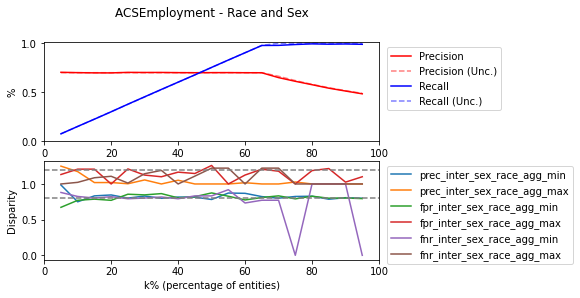

In [3]:
dataset_names = ['ACSEmployment', 'ACSIncome', 'ACSPublicCoverage', 'ACSMobility', 'ACSTravelTime']

results_columns = ['dataset','sample_size','overall_prev','sensitive_attr','group_dist','group_prev','max_group_prev_diff']

fo_results = {}

results_df = pd.DataFrame(
            columns=(results_columns)
)

def maxDiff(a):
    a.sort()
    vmin = a[0]
    dmax = 0
    for i in range(len(a)):
        if (a[i] < vmin):
            vmin = a[i]
        elif (a[i] - vmin > dmax):
            dmax = a[i] - vmin
    return dmax

RAC1P_mapper = {1:1,
                2:2,
                3:4,
                4:4,
                5:4,
                6:3,
                7:4,
                8:4,
                9:4}

SEX_mapper = {1: 1,
              2: 2}

HISP_mapper = {x: 1 if x == 0 else 2 for x in range(0, 24)}

# New codes:
# 1 - White alone
# 2 - Black or African American alone
# 3 - Asian alone
# 4 - Other

race_agg_names = {1: 'White',
                  2: 'Black or African American alone',
                  3: 'Asian alone',
                  4: 'Other'}

# New codes:
# 1 - Male
# 2 - Female

sex_names = {1: 'Male',
             2: 'Female'}

# New codes:
# 1 - Not Hispanic or Latinx
# 2 - Hispanic or Latinx

hisp_names = {1: 'Not Hispanic or Latinx',
              2: 'Hispanic or Latinx'}

sample_dfs = {}

for dataset_name in dataset_names:
    print(f"DEBUG: Working on {dataset_name}")

    # Dict for new record
    r = {}
    r['dataset'] = dataset_name

    features, label, group = eval(dataset_name + '.df_to_numpy(acs_data)')
    feature_names = eval(dataset_name + '.features')

    df = pd.DataFrame(features, columns = feature_names)
    df['label'] = 1*label

    # Recode sex and race
    df['race_agg'] = df['RAC1P'].map(RAC1P_mapper)
    df['sex'] = df['SEX'].map(SEX_mapper)
    #df['hisp'] = df['HISP'].map(HISP_mapper)

    increase_test_size = True
    test_size = 0.01
    while increase_test_size:
        if df.shape[0]*test_size < 1000:
            test_size+=0.01
        else:
            increase_test_size = False
    
    _, sample_df = train_test_split(df, test_size=test_size, stratify=df[['race_agg','sex','label']],random_state=42)
    sample_df = sample_df.reset_index()

    sample_dfs[dataset_name] = sample_df

    r['sample_size'] = sample_df.shape[0]
    r['overall_prev'] = round(sample_df['label'].value_counts(normalize=True)[1]*100, 2)

    sample_df['race_agg_names'] = sample_df['race_agg'].map(race_agg_names)
    sample_df['sex_names'] = sample_df['sex'].map(sex_names)    

    sample_df['sex_race_agg_names'] = sample_df.apply(lambda row: str(row['race_agg_names']) + ', ' + str(row['sex_names']), axis=1)
    
    # Get sex dist
    dist_dict = {}
    dist = sample_df['sex_race_agg_names'].value_counts(normalize=True)
    for x in list(sample_df['sex_race_agg_names'].unique()):
        dist_dict[x] = round(dist[x]*100,2)

    #print(dist_dict)

    # Get sex group prev
    prev_dict = {}
    prev = pd.crosstab(sample_df['sex_race_agg_names'], sample_df['label'], normalize='index')
    for x in list(sample_df['sex_race_agg_names'].unique()):
        prev_dict[x] = round(prev[1][x]*100,2)

    #print(prev_dict)

    max_prev_diff = round(maxDiff(list(prev_dict.values())),2)

    r['sensitive_attr'] = 'Race and Sex'
    r['group_dist'] = dist_dict
    r['group_prev'] = prev_dict
    r['max_group_prev_diff'] = max_prev_diff

    results_df = results_df.append(r, ignore_index=True)

    #print("Sex: ")
    fo = FairnessEvaluator(sample_df,
                        'label',
                        ['sex','race_agg'],
                        metrics=['tpr','fpr','fnr'],
                        metrics_to_plot=['prec','fpr','fnr'],
                        fairness_bounds=[0.8,1.2],
                        fully_constrained=False,
                        #intersectionality='full',
                        precision_ub = 0.7
                        #disparity_ratio=True,
                        #epsilon=0.05
                        )

    fo.evaluate()
    fo.plot()
    plt.title(f'{dataset_name} - Race and Sex', y=2.4)

    key_temp = f'{dataset_name}_race_sex'
    fo_results[key_temp] = fo.results_df

    break

In [4]:
results_df.to_csv('data/folktables-intersectional-results.csv',index=False)